In [1]:
import tensorflow as tf
import numpy as np

計算グラフを定義

In [3]:
g = tf.Graph()

with g.as_default():
    # tensorを定義
    t1 = tf.constant(np.pi)
    t2 = tf.constant([1, 2, 3, 4])
    t3 = tf.constant([[1, 2], [3, 4]])
    
    # tensorのrankを取得
    r1 = tf.rank(t1)
    r2 = tf.rank(t2)
    r3 = tf.rank(t3)
    
    # tensorの形状を取得
    s1 = t1.get_shape()
    s2 = t2.get_shape()
    s3 = t3.get_shape()
    print("shapes: ", s1, s2, s3)

shapes:  () (4,) (2, 2)


In [4]:
with tf.Session(graph=g) as sess:
    print('Rank:',
          r1.eval(),
          r2.eval(),
          r3.eval()
         )

Rank: 0 1 2


計算グラフを構築して計算を実行してみる

$z = 2 * (a - b) + c$  
についての計算グラフ

In [5]:
g = tf.Graph()

# 計算グラフにノードを追加する
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2 * (a - b) + c
    
with tf.Session(graph=g) as sess:
    print('result: ', sess.run(z))

result:  1


プレースホルダの定義

In [7]:
g = tf.Graph()

with g.as_default():
    tf_a = tf.placeholder(tf.int32, shape=[], name='tf_a')
    tf_b = tf.placeholder(tf.int32, shape=[], name='tf_b')
    tf_c = tf.placeholder(tf.int32, shape=[], name='tf_c')
    
    # 中間テンソルを格納
    r1 = tf_a - tf_b
    r2 = 2 * r1
    z = r2 + tf_c

プレースホルダにデータを供給する

In [8]:
with tf.Session(graph=g) as sess:
    feed = {tf_a: 1, tf_b: 2, tf_c: 3}
    print("result: ", sess.run(z, feed_dict=feed))

result:  1


形状がわからないプレースホルダ

In [12]:
g = tf.Graph()

with g.as_default():
    tf_x = tf.placeholder(tf.float32, shape=[None, 2], name='tf_x')
    x_mean = tf.reduce_mean(tf_x, axis=0, name='mean')

np.random.seed(123)
np.set_printoptions(precision=2)

with tf.Session(graph=g) as sess:
    x1 = np.random.uniform(low=0, high=1, size=(5, 2))
    print('feeding data with shape ', x1.shape)
    print('result: ', sess.run(x_mean, feed_dict={tf_x: x1}))
    
    x2 = np.random.uniform(low=0, high=1, size=(10, 2))
    print('feeding data with shape ', x2.shape)
    print('result: ', sess.run(x_mean, feed_dict={tf_x: x2}))

feeding data with shape  (5, 2)
result:  [0.62 0.47]
feeding data with shape  (10, 2)
result:  [0.46 0.49]


In [3]:
g1 = tf.Graph()

with g1.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), name='w')
    print(w)

<tf.Variable 'w:0' shape=(2, 4) dtype=int64_ref>


In [5]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(w))

[[1 2 3 4]
 [5 6 7 8]]


変数のスコープ

In [6]:
g = tf.Graph()

with g.as_default():
    with tf.variable_scope('net_A'):
        with tf.variable_scope('layer-1'):
            w1 = tf.Variable(tf.random_normal(shape=(10,4)), name='weights')
        with tf.variable_scope('layer-2'):
            w2 = tf.Variable(tf.random_normal(shape=(20,10)), name='weights')
    with tf.variable_scope('net_B'):
        with tf.variable_scope('layer-1'):
            w3 = tf.Variable(tf.random_normal(shape=(10,4)), name='weights')
            
    print(w1)
    print(w2)
    print(w3)

<tf.Variable 'net_A/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>
<tf.Variable 'net_A/layer-2/weights:0' shape=(20, 10) dtype=float32_ref>
<tf.Variable 'net_B/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>


TensorFlowで回帰モデルを実装してみる

In [7]:
g = tf.Graph()

with g.as_default():
    tf.set_random_seed(123)
    
    # プレースホルダを定義
    tf_x = tf.placeholder(shape=(None), dtype=tf.float32, name='tf_X')
    tf_y = tf.placeholder(shape=(None), dtype=tf.float32, name='tf_y')
    
    # 変数を定義
    weight = tf.Variable(tf.random_normal(shape=(1, 1), stddev=0.25), name='weight')
    bias = tf.Variable(0.0, name='bias')
    
    # モデルの構築
    y_hat = tf.add(weight * tf_x, bias, name='y_hat')
    
    # コストの計算
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost')
    
    # モデルをトレーニング（する枠組み）
    optim = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

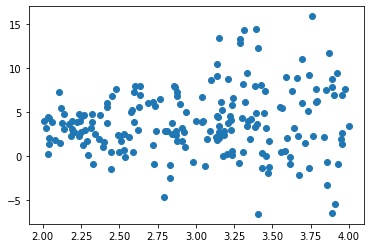

In [11]:
np.random.seed(0)

def make_random_data():
    x = np.random.uniform(low=2, high=4, size=200)
    y = []
    for t in x:
        r = np.random.normal(loc=0.0, scale=(0.5 + t * t / 3), size=None)
        y.append(r)
    return x, 1.726 * x - 0.84 + np.array(y)

x, y = make_random_data()

plt.plot(x, y, 'o')
plt.show()

In [12]:
x_train, y_train = x[:100], y[:100]
x_test, y_test = x[100:], y[100:]

n_epochs = 500
training_costs = []

with tf.Session(graph=g) as sess:
    # 変数の初期化
    sess.run(tf.global_variables_initializer())
    
    # 500epochsでモデルをトレーニング
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op], feed_dict={tf_x: x_train, tf_y: y_train})
        training_costs.append(c)
        if not e % 50:
            print("Epoch {:4d}: {:.4f}".format(e, c))

Epoch    0: 32.7691
Epoch   50: 15.3932
Epoch  100: 13.0766
Epoch  150: 12.7671
Epoch  200: 12.7250
Epoch  250: 12.7187
Epoch  300: 12.7171
Epoch  350: 12.7161
Epoch  400: 12.7152
Epoch  450: 12.7144


In [16]:
501 % 50

1